<a href="https://colab.research.google.com/github/fabiodemo/Deep-Learning-CV-CNN-TL/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download da Base de Dados

In [4]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz

--2022-09-23 23:20:08--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.139.237
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.139.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1343715595 (1.3G) [application/x-tar]
Saving to: ‘imagewoof2.tgz’

imagewoof2.tgz      100%[===================>]   1.25G  35.9MB/s    in 29s     

2022-09-23 23:20:36 (45.0 MB/s) - ‘imagewoof2.tgz’ saved [1343715595/1343715595]



In [5]:
!tar zxvf imagewoof2.tgz

A saída de streaming foi truncada nas últimas 5000 linhas.
imagewoof2/train/n02115641/n02115641_9529.JPEG
imagewoof2/train/n02115641/n02115641_12039.JPEG
imagewoof2/train/n02115641/n02115641_8768.JPEG
imagewoof2/train/n02115641/n02115641_7188.JPEG
imagewoof2/train/n02115641/n02115641_6633.JPEG
imagewoof2/train/n02115641/n02115641_25018.JPEG
imagewoof2/train/n02115641/n02115641_10706.JPEG
imagewoof2/train/n02115641/n02115641_11814.JPEG
imagewoof2/train/n02115641/n02115641_51135.JPEG
imagewoof2/train/n02115641/n02115641_7409.JPEG
imagewoof2/train/n02115641/n02115641_29257.JPEG
imagewoof2/train/n02115641/n02115641_17997.JPEG
imagewoof2/train/n02115641/n02115641_6473.JPEG
imagewoof2/train/n02115641/n02115641_2963.JPEG
imagewoof2/train/n02115641/n02115641_52488.JPEG
imagewoof2/train/n02115641/n02115641_6536.JPEG
imagewoof2/train/n02115641/n02115641_6166.JPEG
imagewoof2/train/n02115641/n02115641_21519.JPEG
imagewoof2/train/n02115641/n02115641_504.JPEG
imagewoof2/train/n02115641/n02115641_140

In [6]:
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
all_train_paths = glob.glob('/content/imagewoof2/train/*/*.JPEG')

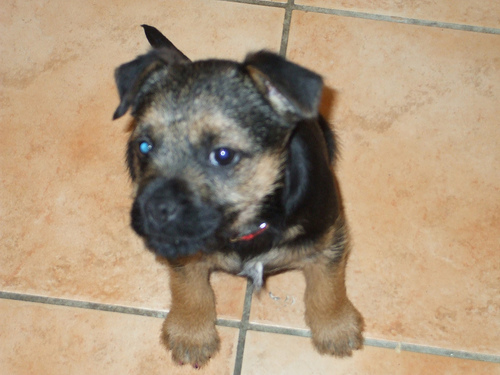

In [8]:
img_path = random.choice(all_train_paths)
Image.open(img_path)

## Declarando ImageDataGenerator

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

In [10]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
train_gen = datagen.flow_from_directory('/content/imagewoof2/train',
                            target_size=(224, 224),
                            class_mode='sparse',
                            )

valid_gen = datagen.flow_from_directory('/content/imagewoof2/val',
                            target_size=(224, 224),
                            class_mode='sparse',
                            )

Found 9025 images belonging to 10 classes.
Found 3929 images belonging to 10 classes.


In [12]:
len(all_train_paths)

9025

## Declarando Modelo

In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [14]:
base_model = ResNet50(include_top=False,
                      input_shape=(224,224,3),
                      )

94781440/94765736 [==============================] - 0s 0us/step


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

Precisamos congelar a camada pré-treinada (reaproveitar os pesos do modelo pré-treinado), mudando o parâmetro individual de cada layer

In [16]:
for layer in base_model.layers:
  layer.trainable=False

In [17]:
model = Sequential([
                    base_model,
                    GlobalAveragePooling2D(),
                    Dense(1024, activation='relu'), # saida terá aprox. 2048 valores, então usamos metade disso para a camada oculta
                    Dense(10, activation='softmax') # softmax retornará probabilidades de cada uma das 10 saídas
                    ])

## Treinar o modelo

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 25,696,138
Trainable params: 2,108,426
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
from tensorflow.keras.optimizers import Adam

In [22]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
model.fit(train_gen,
          validation_data=valid_gen,
          epochs=3)

Epoch 1/3
283/283 [==============================] - 93s 284ms/step - loss: 0.3429 - accuracy: 0.8962 - val_loss: 0.2158 - val_accuracy: 0.9298
Epoch 2/3
256/283 [==========================>...] - ETA: 5s - loss: 0.1425 - accuracy: 0.9538

## Visualizando Predições